In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import chnet.utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.ch_loader import CahnHillDataset

In [4]:
warnings.filterwarnings('ignore')

In [5]:
@curry
def init_norm(nsamples, dim_x, dim_y, seed=354875, m_l=-0.15, m_r=0.15):
    np.random.seed(seed)
    means  = np.random.uniform(m_l, m_r, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.05, 0.3, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data

## Loss Functions

In [6]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Data Generators

In [7]:
@curry
def data_generator_slices(nsamples=2, 
                   dim_x=64, 
                   init_steps=1, 
                   delta_sim_steps = 100,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   n_step = 4,
                   m_l=-0.15, 
                   m_r=0.15,
                   device = torch.device("cuda:0")):
    
    init_data = init_norm(nsamples, dim_x, dim_x, seed=seed, m_l=m_l, m_r=m_r)   

    x_list = []
    y_list = []
    
    x_data = ch.ch_run_torch(init_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, 
                             device=device)    
    

    for _ in range(n_step):
        x_list.append(x_data[None])
        x_data = ch.ch_run_torch(x_data, 
                                 dt=dt, gamma=gamma, 
                                 dx=dx, sim_step=delta_sim_steps, 
                                 device=device)
        y_list.append(x_data[None])
    
    x_data = np.moveaxis(np.concatenate(x_list, axis=0), 0, 1)
    y_data = np.moveaxis(np.concatenate(y_list, axis=0), 0, 1)
    
    return x_data, y_data

# Set Device

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
%%time
x_data, y_data = data_generator_slices(nsamples=2, dim_x=128, 
                                init_steps=1, 
                                delta_sim_steps = 800,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = 23846,
                                device = device)

dataset = CahnHillDataset(x_data, y_data, transform_x=lambda x: x[:,None], transform_y=lambda x: x[:,None])

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 4, 1, 128, 128]) torch.Size([1, 4, 1, 128, 128])
CPU times: user 451 ms, sys: 1.03 ms, total: 452 ms
Wall time: 450 ms


In [24]:
from chnet.lstm_unet import Unet_loop
model = Unet_loop(input_nc=1, output_nc=1, ngf=16, temporal=1, tanh=True).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

y_pred, y_pred_ = model(x[:,0])

print(y_pred.shape)

# assert y.shape == y_pred.shape
# print(mse_loss(y, y_pred).data)

x4 torch.Size([1, 128, 16, 16])
x5 torch.Size([1, 256, 8, 8])
torch.Size([1, 1, 128, 128])


In [14]:
from chnet.lstm_unet import LSTM_Unet
model = LSTM_Unet(input_nc=1, output_nc=1, ngf=16, temporal=4).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)


y_pred, y_pred_ = model(x)

print(y_pred.shape)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

torch.Size([1, 4, 1, 64, 64])
tensor(0.1867, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [15]:
## Process Parameters
dim_x=96
init_steps=1
delta_sim_steps = 400
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 237452 #110364
seed_val = 986423
seed_prd = 284296


trn_size = 5
n_samples_trn = 1024*trn_size

n_step = 5

batch_size = 8

In [16]:
transformer_x = lambda x: x[:,None]
transformer_y = lambda x: x[:,None]

In [17]:
from chnet.lstm_unet import LSTM_Unet

ngf = 32
model = LSTM_Unet(input_nc=1, output_nc=1, ngf=ngf, temporal=n_step, tanh=True).double().to(device)

trn_losses = []
log_step = 512

n_params = 0
for params in model.parameters():
    n_params += np.prod(params.shape)
print(n_params)

8648514


In [32]:
criterion = mse_loss(scale=10000000)
model.load_state_dict(torch.load("out/unet_convLSTM_ch32_step_400_nstep_5_4thtry.pt"))
learning_rate = 0.5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
model.train()
num_epochs = 10
for seed_trn in [98712*23, 14112*29, 15439*31, 92361*37]:
    x_trn, y_trn = data_generator_slices(nsamples=n_samples_trn, 
                                         dim_x=dim_x, 
                                         init_steps=init_steps, 
                                         delta_sim_steps = delta_sim_steps,
                                         dx=dx, 
                                         dt=dt,
                                         n_step=n_step,
                                         gamma=gamma, 
                                         seed=seed_trn,
                                         device=device)

    trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
    trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Loss and optimizer
    for epoch in range(num_epochs):    
                    
        for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):       
            model.train()

            x = item_trn['x'].to(device)
            y_t = item_trn['y'].to(device)

            # Forward pass
            y_p, y_p1 = model(x)
            loss = criterion(y_t, y_p)*10 + criterion(y_t, y_p1)*100
    #         y_p, y_p1 = model(x[:,0])
    #         loss = criterion(y_t[:,-1], y_p) + criterion(y_t, y_p1)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trn_losses.append(np.sqrt(loss.item()))

            if (i) % log_step == 0:                 
                print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}'.format(epoch+1, 
                                                                                    num_epochs, 
                                                                                    i+1, 
                                                                                    len(trn_loader), 
                                                                                    np.mean(trn_losses[-log_step:])))
            

        torch.save(model.state_dict(), "out/unet_convLSTM_ch{}_step_{}_nstep_{}_4thtry.pt".format(ngf, delta_sim_steps, n_step)) 

Epoch [1/10], Step [1/640], Training Loss: 1.39483615333
Epoch [1/10], Step [513/640], Training Loss: 220.08233988095



Epoch [2/10], Step [1/640], Training Loss: 218.29377022996
Epoch [2/10], Step [513/640], Training Loss: 214.39839342623



Epoch [3/10], Step [1/640], Training Loss: 213.50885288567
Epoch [3/10], Step [513/640], Training Loss: 211.95390478060



Epoch [4/10], Step [1/640], Training Loss: 211.92625438366
Epoch [4/10], Step [513/640], Training Loss: 209.85623645599



Epoch [5/10], Step [1/640], Training Loss: 212.67739511843
Epoch [5/10], Step [513/640], Training Loss: 213.86913380342



Epoch [6/10], Step [1/640], Training Loss: 216.72289107440
Epoch [6/10], Step [513/640], Training Loss: 211.35859868105



Epoch [7/10], Step [1/640], Training Loss: 209.20157398161
Epoch [7/10], Step [513/640], Training Loss: 213.63491834436



Epoch [8/10], Step [1/640], Training Loss: 212.25251825831
Epoch [8/10], Step [513/640], Training Loss: 208.41422517217



Epoch [9/10], Step [1/640], Training Loss: 208.44887471788
Epoch [9/10], Step [513/640], Training Loss: 209.38568385711



Epoch [10/10], Step [1/640], Training Loss: 209.26207740944
Epoch [10/10], Step [513/640], Training Loss: 207.84735331589



Epoch [1/10], Step [1/640], Training Loss: 208.61222259659
Epoch [1/10], Step [513/640], Training Loss: 214.47755598629



Epoch [2/10], Step [1/640], Training Loss: 211.07102841405
Epoch [2/10], Step [513/640], Training Loss: 213.74449019577



Epoch [3/10], Step [1/640], Training Loss: 213.16271817664
Epoch [3/10], Step [513/640], Training Loss: 216.67075097705



Epoch [4/10], Step [1/640], Training Loss: 217.70308966201
Epoch [4/10], Step [513/640], Training Loss: 209.04540296312



Epoch [5/10], Step [1/640], Training Loss: 210.30290861041
Epoch [5/10], Step [513/640], Training Loss: 209.84199068060



Epoch [6/10], Step [1/640], Training Loss: 212.78266500512
Epoch [6/10], Step [513/640], Training Loss: 208.07673679009



Epoch [7/10], Step [1/640], Training Loss: 207.66071764464
Epoch [7/10], Step [513/640], Training Loss: 210.68861454047



Epoch [8/10], Step [1/640], Training Loss: 211.18475415755
Epoch [8/10], Step [513/640], Training Loss: 206.38993239446



Epoch [9/10], Step [1/640], Training Loss: 211.36956346798
Epoch [9/10], Step [513/640], Training Loss: 206.92562061328



Epoch [10/10], Step [1/640], Training Loss: 206.17611639007
Epoch [10/10], Step [513/640], Training Loss: 204.91888578437



Epoch [1/10], Step [1/640], Training Loss: 206.45626632304
Epoch [1/10], Step [513/640], Training Loss: 209.73112799734



Epoch [2/10], Step [1/640], Training Loss: 212.32179766893
Epoch [2/10], Step [513/640], Training Loss: 210.37131757148



Epoch [3/10], Step [1/640], Training Loss: 208.60295486843
Epoch [3/10], Step [513/640], Training Loss: 203.44340408805



Epoch [4/10], Step [1/640], Training Loss: 203.27146953380
Epoch [4/10], Step [513/640], Training Loss: 203.90058468665



Epoch [5/10], Step [1/640], Training Loss: 203.07509608916
Epoch [5/10], Step [513/640], Training Loss: 207.16333383542



Epoch [6/10], Step [1/640], Training Loss: 207.58509521523
Epoch [6/10], Step [513/640], Training Loss: 204.29451215430



Epoch [7/10], Step [1/640], Training Loss: 205.91079648542
Epoch [7/10], Step [513/640], Training Loss: 206.13078536092



Epoch [8/10], Step [1/640], Training Loss: 206.92521594773
Epoch [8/10], Step [513/640], Training Loss: 206.35988619352



Epoch [9/10], Step [1/640], Training Loss: 204.64009848487
Epoch [9/10], Step [513/640], Training Loss: 204.95072689425



Epoch [10/10], Step [1/640], Training Loss: 203.46693424859
Epoch [10/10], Step [513/640], Training Loss: 200.35753273738



Epoch [1/10], Step [1/640], Training Loss: 201.10635244185
Epoch [1/10], Step [513/640], Training Loss: 210.23656015709



Epoch [2/10], Step [1/640], Training Loss: 210.76342635628
Epoch [2/10], Step [513/640], Training Loss: 208.90894702183



Epoch [3/10], Step [1/640], Training Loss: 210.11534252025
Epoch [3/10], Step [513/640], Training Loss: 209.17259800807



Epoch [4/10], Step [1/640], Training Loss: 207.44325462808
Epoch [4/10], Step [513/640], Training Loss: 203.71443380394



Epoch [5/10], Step [1/640], Training Loss: 204.09203176975
Epoch [5/10], Step [513/640], Training Loss: 206.66866308405



Epoch [6/10], Step [1/640], Training Loss: 206.94857691659
Epoch [6/10], Step [513/640], Training Loss: 210.94303987408



Epoch [7/10], Step [1/640], Training Loss: 208.84534452485
Epoch [7/10], Step [513/640], Training Loss: 204.36901177522



Epoch [8/10], Step [1/640], Training Loss: 204.46486384120
Epoch [8/10], Step [513/640], Training Loss: 200.37978219013



Epoch [9/10], Step [1/640], Training Loss: 201.04864888184
Epoch [9/10], Step [513/640], Training Loss: 200.98059498634



Epoch [10/10], Step [1/640], Training Loss: 200.88067022161
Epoch [10/10], Step [513/640], Training Loss: 199.35304319739



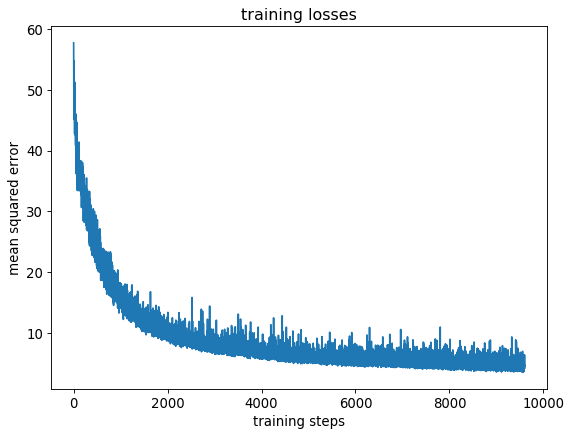

In [91]:
plt.plot(trn_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.show()

In [35]:
model.eval()
x_val, y_val = data_generator_slices(nsamples=32, 
                              dim_x=96, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =174753,
                              n_step=n_step,
                              device = device)

prd_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
err = []
for ix, item_prd in enumerate(prd_dataset):
    x1 = item_prd['x'][None].to(device)
    y1 = item_prd['y'][None].to(device)
    y2, y2_u = model(x1)
    err.append(np.sqrt(mse_loss(y1.detach().cpu(), y2.detach().cpu())))
    
print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))

Mean Error on Validation Set: 0.0489


In [57]:
model.eval()
nsamples=2
x_val, y_val = data_generator_slices(nsamples=nsamples, 
                              dim_x=96, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =174753,
                              n_step=n_step,
                              device = device)



val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=nsamples, shuffle=True, num_workers=1)

total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)

ix = 0

item_prd = next(iter(val_loader))
x1 = item_prd['x'].to(device)
y1 = item_prd['y'].to(device)
y2, y2_u = model.predict(x1[:,0])

im_x1 = x1[ix][0].detach().cpu().numpy()
im_y1 = y1[ix][-1].detach().cpu().numpy()
im_y2 = y2[ix][-1].detach().cpu().numpy()

utils.draw_im(im_x1[0], "inp")
utils.draw_by_side(im_y1[0], im_y2[0], title_left="Sim", title_right="CNN")